# FloPy

## Creating a Complex MODFLOW 6 Model with Flopy

The purpose of this notebook is to demonstrate the Flopy capabilities for building a more complex MODFLOW 6 model from scratch.  This notebook will demonstrate the capabilities by replicating the advgw_tidal model that is distributed with MODFLOW 6.

### Setup the Notebook Environment

In [139]:
%matplotlib inline
import sys
import os
import platform
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.5.3 |Anaconda 4.4.0 (x86_64)| (default, Mar  6 2017, 12:15:08) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
numpy version: 1.12.1
matplotlib version: 2.0.2
flopy version: 3.2.6


In [140]:
# For this example, we will set up a model workspace.
# Model input files and output files will reside here.
model_name = 'advgw_tidal'
workspace = os.path.join('data', model_name)
if not os.path.exists(workspace):
    os.makedirs(workspace)

In [141]:
data_pth = os.path.join('..', 'data', 'mf6', 'create_tests', 
                        'test005_advgw_tidal')
assert os.path.isdir(data_pth)

In [142]:
# create simulation
sim = flopy.mf6.MFSimulation(sim_name=model_name, version='mf6', exe_name='mf6', 
                             sim_ws=workspace, sim_tdis_file='simulation.tdis')

# create tdis package
tdis_rc = [(1.0, 1, 1.0), (10.0, 120, 1.0), 
           (10.0, 120, 1.0), (10.0, 120, 1.0)]
tdis = flopy.mf6.ModflowTdis(sim, time_units='DAYS', 
                             nper=4, tdisrecarray=tdis_rc)

# create gwf model
gwf = flopy.mf6.MFModel(sim, model_type='gwf6', model_name=model_name,
                        model_nam_file='{}.nam'.format(model_name),
                        ims_file_name='{}.ims'.format(model_name))
gwf.name_file.save_flows = True

# create iterative model solution and register the gwf model with it
ims = flopy.mf6.ModflowIms(sim, print_option='SUMMARY', complexity='SIMPLE', 
                           outer_hclose=0.0001, outer_maximum=500, 
                           under_relaxation='NONE', inner_maximum=100,
                           inner_hclose=0.0001, rcloserecord=0.001, 
                           linear_acceleration='CG', scaling_method='NONE', 
                           reordering_method='NONE', relaxation_factor=0.97)
sim.register_ims_package(ims, [gwf.name])

Directory structure already exists for simulation path /Users/langevin/langevin/dev/flopy3.git/examples/Notebooks/data/advgw_tidal


In [166]:
# discretization package
nlay = 3
nrow = 15
ncol = 10
botlay2 = {'factor':1.0, 'data': [-100 for x in range(150)]}
dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol, delr=500.0, delc=500.0,
                              top=50.0, botm=[5.0, -10.0, botlay2],
                              fname='{}.dis'.format(model_name))

# initial conditions
ic = flopy.mf6.ModflowGwfic(gwf, strt=50.0,
                            fname='{}.ic'.format(model_name))

# node property flow
npf = flopy.mf6.ModflowGwfnpf(gwf, save_flows=True, 
                              icelltype=[1,0,0], 
                              k=[5.0, 0.1, 4.0],
                              k33=[0.5, 0.005, 0.1])

# output control
oc = flopy.mf6.ModflowGwfoc(gwf, budget_filerecord='{}.cbb'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            headprintrecord=[('COLUMNS', 10, 'WIDTH', 15,
                                              'DIGITS', 6, 'GENERAL')],
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                            printrecord=[('HEAD', 'FIRST'), ('HEAD', 'LAST'), 
                                         ('BUDGET', 'LAST')])

In [144]:
# storage package
sy = flopy.mf6.ModflowGwfsto.sy.empty(gwf, layered=True)
for layer in range(0,3):
    sy[layer]['data'] = 0.2
    
ss = flopy.mf6.ModflowGwfsto.ss.empty(gwf, layered=True, default_value=0.000001)

sto = flopy.mf6.ModflowGwfsto(gwf, save_flows=True, iconvert=1, ss=ss, 
                              sy=sy, steady_state={0:True},
                              transient={1:True})

In [145]:
# well package
# test empty with aux vars, bound names, and time series
period_two = flopy.mf6.ModflowGwfwel.periodrecarray.empty(gwf, maxbound=3, aux_vars=['var1', 'var2', 'var3'],
                                                         boundnames=True, timeseries=True)
period_two[0][0] = ((0,11,2), -50.0, -1, -2, -3, None)
period_two[0][1] = ((2,4,7), 'well_1_rate', 1, 2, 3, 'well_1')
period_two[0][2] = ((2,3,2), 'well_2_rate', 4, 5, 6, 'well_2')
period_three = flopy.mf6.ModflowGwfwel.periodrecarray.empty(gwf, maxbound=2, aux_vars=['var1', 'var2', 'var3'],
                                                           boundnames=True, timeseries=True)
period_three[0][0] = ((2,3,2), 'well_2_rate', 1, 2, 3, 'well_2')
period_three[0][1] = ((2,4,7), 'well_1_rate', 4, 5, 6, 'well_1')
period_four = flopy.mf6.ModflowGwfwel.periodrecarray.empty(gwf, maxbound=5, aux_vars=['var1', 'var2', 'var3'],
                                                          boundnames=True, timeseries=True)
period_four[0][0] = ((2,4,7), 'well_1_rate', 1, 2, 3, 'well_1')
period_four[0][1] = ((2,3,2), 'well_2_rate', 4, 5, 6, 'well_2')
period_four[0][2] = ((0,11,2), -10.0, 7, 8, 9, None)
period_four[0][3] = ((0,2,4), -20.0, 17, 18, 19, None)
period_four[0][4] = ((0,13,5), -40.0, 27, 28, 29, None)
periodrecarray = {}
periodrecarray[1] = period_two[0]
periodrecarray[2] = period_three[0]
periodrecarray[3] = period_four[0]
wel = flopy.mf6.ModflowGwfwel(gwf, print_input=True, print_flows=True,
                              auxiliary=[('var1', 'var2', 'var3')], maxbound=5,
                              periodrecarray=periodrecarray, boundnames=True, 
                              save_flows=True,
                              ts_filerecord='well-rates.ts')

# well ts package
ts_recarray =[(0.0, 0.0, 0.0, 0.0),
              (1.0, -200.0, 0.0, -100.0),
              (11.0, -1800.0, -500.0, -200.0),
              (21.0, -200.0, -400.0, -300.0),
              (31.0, 0.0, -600.0, -400.0)]
well_ts_package = flopy.mf6.ModflowUtlts(gwf, fname='well-rates.ts', parent_file=wel,
                                         time_seriesrecarray=ts_recarray,
                                         time_series_namerecord=[('well_1_rate', 'well_2_rate', 'well_3_rate')],
                                         interpolation_methodrecord=[('stepwise', 'stepwise', 'stepwise')])

In [146]:
# Evapotranspiration
evt_period = flopy.mf6.ModflowGwfevt.periodrecarray.empty(gwf, 150, nseg=3)
for col in range(0, 10):
    for row in range(0, 15):
        evt_period[0][col*15+row] = (((0, row, col), 50.0, 0.0004, 10.0, 0.2, 0.5, 0.3, 0.1, None))
evt = flopy.mf6.ModflowGwfevt(gwf, print_input=True, print_flows=True, 
                              save_flows=True, maxbound=150,
                              nseg=3, periodrecarray=evt_period)

In [147]:
# General-Head Boundaries
ghb_period = {}
ghb_period_array = []
for layer, cond in zip(range(1, 3), [15.0, 1500.0]):
    for row in range(0, 15):
        ghb_period_array.append(((layer, row, 9), 'tides', cond, 'Estuary-L2'))
ghb_period[0] = ghb_period_array
ghb = flopy.mf6.ModflowGwfghb(gwf, print_input=True, print_flows=True, 
                              save_flows=True, boundnames=True,
                              ts_filerecord='tides.ts', 
                              obs_filerecord='{}.ghb.obs'.format(model_name),
                              maxbound=30, periodrecarray=ghb_period)
ts_recarray=[]
fd = open(os.path.join(data_pth, 'tides.txt'), 'r')
for line in fd:
    line_list = line.strip().split(',')
    ts_recarray.append((float(line_list[0]), float(line_list[1])))
ghb_ts_package = flopy.mf6.ModflowUtlts(gwf, fname='tides.ts', parent_file=ghb,
                                        time_seriesrecarray=ts_recarray,
                                        time_series_namerecord='tides',
                                        interpolation_methodrecord='linear')
obs_recarray = {'ghb_obs.csv':[('ghb-2-6-10', 'GHB', (1, 5, 9)), 
                               ('ghb-3-6-10', 'GHB', (2, 5, 9))],
                'ghb_flows.csv':[('Estuary2', 'GHB', 'Estuary-L2'), 
                                 ('Estuary3', 'GHB', 'Estuary-L3')]}
ghb_obs_package = flopy.mf6.ModflowUtlobs(gwf, fname='{}.ghb.obs'.format(model_name), 
                                          parent_file=ghb, digits=10, 
                                          print_input=True, continuousrecarray=obs_recarray)

In [148]:
obs_recarray = {'head_obs.csv':[('h1_13_8', 'HEAD', (2, 12, 7))],
                'intercell_flow_obs1.csv':[('ICF1_1.0', 'FLOW-JA-FACE', (0, 4, 5), (0, 5, 5))],
                'head-hydrographs.csv':[('h3-13-9', 'HEAD', (2, 12, 8)),
                                        ('h3-12-8', 'HEAD', (2, 11, 7)),
                                        ('h1-4-3', 'HEAD', (0, 3, 2)),
                                        ('h1-12-3', 'HEAD', (0, 11, 2)),
                                        ('h1-13-9', 'HEAD', (0, 12, 8))]}
obs_package = flopy.mf6.ModflowUtlobs(gwf, fname='{}.obs'.format(model_name), 
                                      digits=10, print_input=True,
                                      continuousrecarray=obs_recarray)

In [149]:
# River
riv_period = {}
riv_period_array = [((0,2,0),'river_stage_1',1001.0,35.9,None),
                    ((0,3,1),'river_stage_1',1002.0,35.8,None),
                    ((0,4,2),'river_stage_1',1003.0,35.7,None),
                    ((0,4,3),'river_stage_1',1004.0,35.6,None),
                    ((0,5,4),'river_stage_1',1005.0,35.5,None),
                    ((0,5,5),'river_stage_1',1006.0,35.4,'riv1_c6'),
                    ((0,5,6),'river_stage_1',1007.0,35.3,'riv1_c7'),
                    ((0,4,7),'river_stage_1',1008.0,35.2,None),
                    ((0,4,8),'river_stage_1',1009.0,35.1,None),
                    ((0,4,9),'river_stage_1',1010.0,35.0,None),
                    ((0,9,0),'river_stage_2',1001.0,36.9,'riv2_upper'),
                    ((0,8,1),'river_stage_2',1002.0,36.8,'riv2_upper'),
                    ((0,7,2),'river_stage_2',1003.0,36.7,'riv2_upper'),
                    ((0,6,3),'river_stage_2',1004.0,36.6,None),
                    ((0,6,4),'river_stage_2',1005.0,36.5,None),
                    ((0,5,5),'river_stage_2',1006.0,36.4,'riv2_c6'),
                    ((0,5,6),'river_stage_2',1007.0,36.3,'riv2_c7'),
                    ((0,6,7),'river_stage_2',1008.0,36.2,None),
                    ((0,6,8),'river_stage_2',1009.0,36.1),
                    ((0,6,9),'river_stage_2',1010.0,36.0)]
riv_period[0] = riv_period_array
riv = flopy.mf6.ModflowGwfriv(gwf, print_input=True, print_flows=True, 
                              save_flows='{}.cbc'.format(model_name),
                              boundnames=True, ts_filerecord='river_stages.ts',
                              maxbound=20, periodrecarray=riv_period, 
                              obs_filerecord='{}.riv.obs'.format(model_name))
ts_recarray=[(0.0,40.0,41.0),(1.0,41.0,41.5),
             (2.0,43.0,42.0),(3.0,45.0,42.8),
             (4.0,44.0,43.0),(6.0,43.0,43.1),
             (9.0,42.0,42.4),(11.0,41.0,41.5),
             (31.0,40.0,41.0)]
riv_ts_package = flopy.mf6.ModflowUtlts(gwf, fname='river_stages.ts', 
                                        parent_file=riv,
                                        time_seriesrecarray=ts_recarray,
                                        time_series_namerecord=[('river_stage_1', 
                                                                 'river_stage_2')],
                                        interpolation_methodrecord=[('linear', 'stepwise')])
obs_recarray = {'riv_obs.csv':[('rv1-3-1', 'RIV', (0,2,0)), ('rv1-4-2', 'RIV', (0,3,1)),
                               ('rv1-5-3', 'RIV', (0,4,2)), ('rv1-5-4', 'RIV', (0,4,3)),
                               ('rv1-6-5', 'RIV', (0,5,4)), ('rv1-c6', 'RIV', 'riv1_c6'),
                               ('rv1-c7', 'RIV', 'riv1_c7'), ('rv2-upper', 'RIV', 'riv2_upper'),
                               ('rv-2-7-4', 'RIV', (0,6,3)), ('rv2-8-5', 'RIV', (0,6,4)),
                               ('rv-2-9-6', 'RIV', (0,5,5,))],
                'riv_flowsA.csv':[('riv1-3-1', 'RIV', (0,2,0)), ('riv1-4-2', 'RIV', (0,3,1)),
                                  ('riv1-5-3', 'RIV', (0,4,2))],
                'riv_flowsB.csv':[('riv2-10-1', 'RIV', (0,9,0)), ('riv-2-9-2', 'RIV', (0,8,1)),
                                  ('riv2-8-3', 'RIV', (0,7,2))]}
riv_obs_package = flopy.mf6.ModflowUtlobs(gwf, fname='{}.riv.obs'.format(model_name), 
                                          parent_file=riv, digits=10,
                                          print_input=True, continuousrecarray=obs_recarray)

In [150]:
# First recharge package
rch1_period = {}
rch1_period_array = []
col_range = {0:3,1:4,2:5}
for row in range(0, 15):
    if row in col_range:
        col_max = col_range[row]
    else:
        col_max = 6
    for col in range(0, col_max):
        if (row == 3 and col == 5) or (row == 2 and col == 4) or (row == 1 and col == 3) or (row == 0 and col == 2):
            mult = 0.5
        else:
            mult = 1.0
        if row == 0 and col == 0:
            bnd = 'rch-1-1'
        elif row == 0 and col == 1:
            bnd = 'rch-1-2'
        elif row == 1 and col == 2:
            bnd = 'rch-2-3'
        else:
            bnd = None
        rch1_period_array.append(((0, row, col), 'rch_1', mult, bnd))
rch1_period[0] = rch1_period_array
rch1 = flopy.mf6.ModflowGwfrch(gwf, fname='{}_1.rch'.format(model_name), 
                               pname='rch_1', fixed_cell=True,
                               auxiliary='MULTIPLIER', auxmultname='MULTIPLIER',
                               print_input=True, print_flows=True, 
                               save_flows=True, boundnames=True,
                               ts_filerecord='recharge_rates_1.ts', 
                               maxbound=84, periodrecarray=rch1_period)
ts_recarray=[(0.0, 0.0015), (1.0, 0.0010),
             (11.0, 0.0015),(21.0, 0.0025),
             (31.0, 0.0015)]
rch1_ts_package = flopy.mf6.ModflowUtlts(gwf, fname='recharge_rates_1.ts', 
                                         parent_file=rch1,
                                         time_seriesrecarray=ts_recarray,
                                         time_series_namerecord='rch_1',
                                         interpolation_methodrecord='stepwise')

In [151]:
# Second recharge package
rch2_period = {}
rch2_period_array = [((0,0,2), 'rch_2', 0.5),
                     ((0,0,3), 'rch_2', 1.0),
                     ((0,0,4), 'rch_2', 1.0),
                     ((0,0,5), 'rch_2', 1.0),
                     ((0,0,6), 'rch_2', 1.0),
                     ((0,0,7), 'rch_2', 1.0),
                     ((0,0,8), 'rch_2', 1.0),
                     ((0,0,9), 'rch_2', 0.5),
                     ((0,1,3), 'rch_2', 0.5),
                     ((0,1,4), 'rch_2', 1.0),
                     ((0,1,5), 'rch_2', 1.0),
                     ((0,1,6), 'rch_2', 1.0),
                     ((0,1,7), 'rch_2', 1.0),
                     ((0,1,8), 'rch_2', 0.5),
                     ((0,2,4), 'rch_2', 0.5),
                     ((0,2,5), 'rch_2', 1.0),
                     ((0,2,6), 'rch_2', 1.0),
                     ((0,2,7), 'rch_2', 0.5),
                     ((0,3,5), 'rch_2', 0.5),
                     ((0,3,6), 'rch_2', 0.5)]
rch2_period[0] = rch2_period_array
rch2 = flopy.mf6.ModflowGwfrch(gwf, fname='{}_2.rch'.format(model_name), 
                               pname='rch_2', fixed_cell=True,
                               auxiliary='MULTIPLIER', auxmultname='MULTIPLIER',
                               print_input=True, print_flows=True, save_flows=True,
                               ts_filerecord='recharge_rates_2.ts', maxbound=20, 
                               periodrecarray=rch2_period)
ts_recarray=[(0.0, 0.0016), (1.0, 0.0018),
             (11.0, 0.0019),(21.0, 0.0016),
             (31.0, 0.0018)]
rch2_ts_package = flopy.mf6.ModflowUtlts(gwf, fname='recharge_rates_2.ts', 
                                         parent_file=rch2,
                                         time_seriesrecarray=ts_recarray,
                                         time_series_namerecord='rch_2',
                                         interpolation_methodrecord='linear')

In [152]:
# Third recharge package
rch3_period = {}
rch3_period_array = []
col_range = {0:9,1:8,2:7}
for row in range(0, 15):
    if row in col_range:
        col_min = col_range[row]
    else:
        col_min = 6
    for col in range(col_min, 10):
        if (row == 0 and col == 9) or (row == 1 and col == 8) or (row == 2 and col == 7) or (row == 3 and col == 6):
            mult = 0.5
        else:
            mult = 1.0
        rch3_period_array.append(((0, row, col), 'rch_3', mult))
rch3_period[0] = rch3_period_array
rch3 = flopy.mf6.ModflowGwfrch(gwf, fname='{}_3.rch'.format(model_name), 
                               pname='rch_3', fixed_cell=True,
                               auxiliary='MULTIPLIER', auxmultname='MULTIPLIER',
                               print_input=True, print_flows=True, save_flows=True,
                               ts_filerecord='recharge_rates_3.ts', maxbound=54, 
                               periodrecarray=rch3_period)
ts_recarray=[(0.0, 0.0017),(1.0, 0.0020),(11.0, 0.0017),(21.0, 0.0018),(31.0, 0.0020)]
rch3_ts_package = flopy.mf6.ModflowUtlts(gwf, fname='recharge_rates_3.ts', 
                                         parent_file=rch3,
                                         time_seriesrecarray=ts_recarray,
                                         time_series_namerecord='rch_3',
                                         interpolation_methodrecord='linear')

### Create the MODFLOW 6 Input Files and Run the Model

Once all the flopy objects are created, it is very easy to create all of the input files and run the model.

In [153]:
# change folder to save simulation
#sim.simulation_data.mfpath.set_sim_path(run_folder)

In [154]:
# write simulation to new location
sim.write_simulation()

INFORMATION: 0 external files copied


In [155]:
# Print a list of the files that were created
# in workspace
print(os.listdir(workspace))

['.riv.obs', 'advgw_tidal.cbc', 'advgw_tidal.dis', 'advgw_tidal.dis.grb', 'advgw_tidal.evt', 'advgw_tidal.ghb', 'advgw_tidal.ghb.obs', 'advgw_tidal.hds', 'advgw_tidal.ic', 'advgw_tidal.ims', 'advgw_tidal.lst', 'advgw_tidal.nam', 'advgw_tidal.npf', 'advgw_tidal.obs', 'advgw_tidal.oc', 'advgw_tidal.riv', 'advgw_tidal.riv.obs', 'advgw_tidal.sto', 'advgw_tidal.tdis', 'advgw_tidal.wel', 'advgw_tidal_1.rch', 'advgw_tidal_2.rch', 'advgw_tidal_3.rch', 'ghb_flows.csv', 'ghb_obs.csv', 'head-hydrographs.csv', 'head_obs.csv', 'intercell_flow_obs1.csv', 'mfsim.lst', 'mfsim.nam', 'recharge_rates_1.ts', 'recharge_rates_2.ts', 'recharge_rates_3.ts', 'riv_flowsA.csv', 'riv_flowsB.csv', 'riv_obs.csv', 'river_stages.ts', 'tides.ts', 'well-rates.ts']


### Run the Simulation

We can also run the simulation from the notebook, but only if the MODFLOW 6 executable is available.  The executable can be made available by putting the executable in a folder that is listed in the system path variable.  Another option is to just put a copy of the executable in the simulation folder, though this should generally be avoided.  A final option is to provide a full path to the executable when the simulation is constructed.  This would be done by specifying exe_name with the full path.

In [156]:
# Run the simulation
success, buff = sim.run_simulation()
print('\nSuccess is: ', success)

FloPy is using the following executable to run the model: /Users/langevin/langevin/bin/mac/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                          VERSION mf6.0.1 Sep 28, 2017

  MODFLOW 6 compiled Nov 11 2017 05:49:30 with GFORTRAN compiler (ver. 6.4.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS 

 Solving:  Stress period:     3    Time step:   106
 Solving:  Stress period:     3    Time step:   107
 Solving:  Stress period:     3    Time step:   108
 Solving:  Stress period:     3    Time step:   109
 Solving:  Stress period:     3    Time step:   110
 Solving:  Stress period:     3    Time step:   111
 Solving:  Stress period:     3    Time step:   112
 Solving:  Stress period:     3    Time step:   113
 Solving:  Stress period:     3    Time step:   114
 Solving:  Stress period:     3    Time step:   115
 Solving:  Stress period:     3    Time step:   116
 Solving:  Stress period:     3    Time step:   117
 Solving:  Stress period:     3    Time step:   118
 Solving:  Stress period:     3    Time step:   119
 Solving:  Stress period:     3    Time step:   120
 Solving:  Stress period:     4    Time step:     1
 Solving:  Stress period:     4    Time step:     2
 Solving:  Stress period:     4    Time step:     3
 Solving:  Stress period:     4    Time step:     4
 Solving:  S

### Post-Process Head Results

Post-processing MODFLOW 6 results is still a work in progress.  There aren't any Flopy plotting functions built in yet, like they are for other MODFLOW versions.  So we need to plot the results using general Flopy capabilities.  We can also use some of the Flopy ModelMap capabilities for MODFLOW 6, but in order to do so, we need to manually create a SpatialReference object, that is needed for the plotting.  Examples of both approaches are shown below.

First, a link to the heads file is created with `HeadFile`. The link can then be accessed with the `get_data` function, by specifying, in this case, the step number and period number for which we want to retrieve data. A three-dimensional array is returned of size `nlay, nrow, ncol`. Matplotlib contouring functions are used to make contours of the layers or a cross-section.

In [157]:
# Read the binary head file and plot the results
# We can use the existing Flopy HeadFile class because
# the format of the headfile for MODFLOW 6 is the same
# as for previous MODFLOW verions
headfile = '{}.hds'.format(model_name)
fname = os.path.join(workspace, headfile)
hds = flopy.utils.binaryfile.HeadFile(fname)
h = hds.get_data()

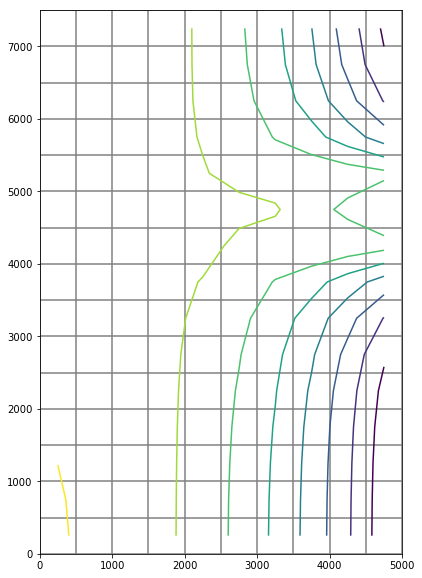

In [158]:
# We can also use the Flopy model map capabilities for MODFLOW 6
# but in order to do so, we need to manually create a
# SpatialReference object
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
sr = flopy.utils.reference.SpatialReference(delr=dis.delr[:],
                                            delc=dis.delc[:])

# Next we create an instance of the ModelMap class
modelmap = flopy.plot.ModelMap(sr=sr)

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
#quadmesh = modelmap.plot_ibound(ibound=ibd)
linecollection = modelmap.plot_grid()
contours = modelmap.contour_array(h[0])

### Post-Process Flows

MODFLOW 6 writes a binary grid file, which contains information about the model grid.  MODFLOW 6 also writes a binary budget file, which contains flow information.  Both of these files can be read using Flopy capabilities.  The MfGrdFile class in Flopy can be used to read the binary grid file.  The CellBudgetFile class in Flopy can be used to read the binary budget file written by MODFLOW 6.

In [159]:
# read the binary grid file
fname = os.path.join(workspace, '{}.dis.grb'.format(model_name))
bgf = flopy.utils.mfgrdfile.MfGrdFile(fname)

# data read from the binary grid file is stored in a dictionary
bgf._datadict

OrderedDict([('NCELLS', 450),
             ('NLAY', 3),
             ('NROW', 15),
             ('NCOL', 10),
             ('NJA', 2700),
             ('XORIGIN', 0.0),
             ('YORIGIN', 0.0),
             ('ANGROT', 0.0),
             ('DELR',
              array([ 500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.])),
             ('DELC',
              array([ 500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,
                      500.,  500.,  500.,  500.,  500.,  500.])),
             ('TOP',
              array([ 50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.,
                      50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.,
                      50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.,
                      50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.,
                      50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.,
                      50.,

In [160]:
# Information from the binary grid file is easily retrieved
ia = bgf._datadict['IA'] - 1
ja = bgf._datadict['JA'] - 1

In [161]:
# read the cell budget file
fname = os.path.join(workspace, '{}.cbb'.format(model_name))
cbb = flopy.utils.CellBudgetFile(fname, precision='double')
cbb.list_records()

flowja = cbb.get_data(text='FLOW-JA-FACE')[0][0, 0, :]
chdflow = cbb.get_data(text='CHD')[0]

(1, 1, b'          STO-SS', 10, 15, -3, 1,  1.,  1.,  1., b'', b'', b'', b'')
(1, 1, b'          STO-SY', 10, 15, -3, 1,  1.,  1.,  1., b'', b'', b'', b'')
(1, 1, b'    FLOW-JA-FACE', 2700, 1, -1, 1,  1.,  1.,  1., b'', b'', b'', b'')
(1, 1, b'             WEL', 10, 15, -3, 6,  1.,  1.,  1., b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'WEL             ')
(1, 1, b'             RIV', 10, 15, -3, 6,  1.,  1.,  1., b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RIV_0           ')
(1, 1, b'             GHB', 10, 15, -3, 6,  1.,  1.,  1., b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(1, 1, b'             RCH', 10, 15, -3, 6,  1.,  1.,  1., b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(1, 1, b'             RCH', 10, 15, -3, 6,  1.,  1.,  1., b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(1, 1, b'             RCH', 10, 15, -3, 6,  1.,  1.,  1

(5, 2, b'             EVT', 10, 15, -3, 6,  0.08333333,  0.41666667,  1.41666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'EVT             ')
(6, 2, b'          STO-SS', 10, 15, -3, 1,  0.08333333,  0.5,  1.5, b'', b'', b'', b'')
(6, 2, b'          STO-SY', 10, 15, -3, 1,  0.08333333,  0.5,  1.5, b'', b'', b'', b'')
(6, 2, b'    FLOW-JA-FACE', 2700, 1, -1, 1,  0.08333333,  0.5,  1.5, b'', b'', b'', b'')
(6, 2, b'             WEL', 10, 15, -3, 6,  0.08333333,  0.5,  1.5, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'WEL             ')
(6, 2, b'             RIV', 10, 15, -3, 6,  0.08333333,  0.5,  1.5, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RIV_0           ')
(6, 2, b'             GHB', 10, 15, -3, 6,  0.08333333,  0.5,  1.5, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(6, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  0.5,  1.5, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'A

(16, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  1.33333333,  2.33333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(16, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  1.33333333,  2.33333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(16, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  1.33333333,  2.33333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_3           ')
(16, 2, b'             EVT', 10, 15, -3, 6,  0.08333333,  1.33333333,  2.33333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'EVT             ')
(17, 2, b'          STO-SS', 10, 15, -3, 1,  0.08333333,  1.41666667,  2.41666667, b'', b'', b'', b'')
(17, 2, b'          STO-SY', 10, 15, -3, 1,  0.08333333,  1.41666667,  2.41666667, b'', b'', b'', b'')
(17, 2, b'    FLOW-JA-FACE', 2700, 1, -1, 1,  0.08333333,  1.41666667,  2.41666667, b'', b'', b'', b'')
(17, 2, b'            

(27, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  2.25,  3.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(27, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  2.25,  3.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_3           ')
(27, 2, b'             EVT', 10, 15, -3, 6,  0.08333333,  2.25,  3.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'EVT             ')
(28, 2, b'          STO-SS', 10, 15, -3, 1,  0.08333333,  2.33333333,  3.33333333, b'', b'', b'', b'')
(28, 2, b'          STO-SY', 10, 15, -3, 1,  0.08333333,  2.33333333,  3.33333333, b'', b'', b'', b'')
(28, 2, b'    FLOW-JA-FACE', 2700, 1, -1, 1,  0.08333333,  2.33333333,  3.33333333, b'', b'', b'', b'')
(28, 2, b'             WEL', 10, 15, -3, 6,  0.08333333,  2.33333333,  3.33333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'WEL             ')
(28, 2, b'             RIV', 10, 15, -3, 6,  0.08333333,  

(34, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  2.83333333,  3.83333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(34, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  2.83333333,  3.83333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(34, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  2.83333333,  3.83333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_3           ')
(34, 2, b'             EVT', 10, 15, -3, 6,  0.08333333,  2.83333333,  3.83333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'EVT             ')
(35, 2, b'          STO-SS', 10, 15, -3, 1,  0.08333333,  2.91666667,  3.91666667, b'', b'', b'', b'')
(35, 2, b'          STO-SY', 10, 15, -3, 1,  0.08333333,  2.91666667,  3.91666667, b'', b'', b'', b'')
(35, 2, b'    FLOW-JA-FACE', 2700, 1, -1, 1,  0.08333333,  2.91666667,  3.91666667, b'', b'', b'', b'')
(35, 2, b'            

(41, 2, b'             RIV', 10, 15, -3, 6,  0.08333333,  3.41666667,  4.41666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RIV_0           ')
(41, 2, b'             GHB', 10, 15, -3, 6,  0.08333333,  3.41666667,  4.41666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(41, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  3.41666667,  4.41666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(41, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  3.41666667,  4.41666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(41, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  3.41666667,  4.41666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_3           ')
(41, 2, b'             EVT', 10, 15, -3, 6,  0.08333333,  3.41666667,  4.41666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'EVT             '

(47, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  3.91666667,  4.91666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(47, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  3.91666667,  4.91666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_3           ')
(47, 2, b'             EVT', 10, 15, -3, 6,  0.08333333,  3.91666667,  4.91666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'EVT             ')
(48, 2, b'          STO-SS', 10, 15, -3, 1,  0.08333333,  4.,  5., b'', b'', b'', b'')
(48, 2, b'          STO-SY', 10, 15, -3, 1,  0.08333333,  4.,  5., b'', b'', b'', b'')
(48, 2, b'    FLOW-JA-FACE', 2700, 1, -1, 1,  0.08333333,  4.,  5., b'', b'', b'', b'')
(48, 2, b'             WEL', 10, 15, -3, 6,  0.08333333,  4.,  5., b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'WEL             ')
(48, 2, b'             RIV', 10, 15, -3, 6,  0.08333333,  4.,  5., b'ADVGW_TIDAL     '

(54, 2, b'             WEL', 10, 15, -3, 6,  0.08333333,  4.5,  5.5, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'WEL             ')
(54, 2, b'             RIV', 10, 15, -3, 6,  0.08333333,  4.5,  5.5, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RIV_0           ')
(54, 2, b'             GHB', 10, 15, -3, 6,  0.08333333,  4.5,  5.5, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(54, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  4.5,  5.5, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(54, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  4.5,  5.5, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(54, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  4.5,  5.5, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_3           ')
(54, 2, b'             EVT', 10, 15, -3, 6,  0.08333333,  4.5,  5.5, b'ADVGW_TIDAL

(61, 2, b'          STO-SS', 10, 15, -3, 1,  0.08333333,  5.08333333,  6.08333333, b'', b'', b'', b'')
(61, 2, b'          STO-SY', 10, 15, -3, 1,  0.08333333,  5.08333333,  6.08333333, b'', b'', b'', b'')
(61, 2, b'    FLOW-JA-FACE', 2700, 1, -1, 1,  0.08333333,  5.08333333,  6.08333333, b'', b'', b'', b'')
(61, 2, b'             WEL', 10, 15, -3, 6,  0.08333333,  5.08333333,  6.08333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'WEL             ')
(61, 2, b'             RIV', 10, 15, -3, 6,  0.08333333,  5.08333333,  6.08333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RIV_0           ')
(61, 2, b'             GHB', 10, 15, -3, 6,  0.08333333,  5.08333333,  6.08333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(61, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  5.08333333,  6.08333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(61, 2, b'            

(67, 2, b'             RIV', 10, 15, -3, 6,  0.08333333,  5.58333333,  6.58333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RIV_0           ')
(67, 2, b'             GHB', 10, 15, -3, 6,  0.08333333,  5.58333333,  6.58333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(67, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  5.58333333,  6.58333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(67, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  5.58333333,  6.58333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(67, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  5.58333333,  6.58333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_3           ')
(67, 2, b'             EVT', 10, 15, -3, 6,  0.08333333,  5.58333333,  6.58333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'EVT             '

(74, 2, b'          STO-SY', 10, 15, -3, 1,  0.08333333,  6.16666667,  7.16666667, b'', b'', b'', b'')
(74, 2, b'    FLOW-JA-FACE', 2700, 1, -1, 1,  0.08333333,  6.16666667,  7.16666667, b'', b'', b'', b'')
(74, 2, b'             WEL', 10, 15, -3, 6,  0.08333333,  6.16666667,  7.16666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'WEL             ')
(74, 2, b'             RIV', 10, 15, -3, 6,  0.08333333,  6.16666667,  7.16666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RIV_0           ')
(74, 2, b'             GHB', 10, 15, -3, 6,  0.08333333,  6.16666667,  7.16666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(74, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  6.16666667,  7.16666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(74, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  6.16666667,  7.16666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', 

(80, 2, b'             EVT', 10, 15, -3, 6,  0.08333333,  6.66666667,  7.66666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'EVT             ')
(81, 2, b'          STO-SS', 10, 15, -3, 1,  0.08333333,  6.75,  7.75, b'', b'', b'', b'')
(81, 2, b'          STO-SY', 10, 15, -3, 1,  0.08333333,  6.75,  7.75, b'', b'', b'', b'')
(81, 2, b'    FLOW-JA-FACE', 2700, 1, -1, 1,  0.08333333,  6.75,  7.75, b'', b'', b'', b'')
(81, 2, b'             WEL', 10, 15, -3, 6,  0.08333333,  6.75,  7.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'WEL             ')
(81, 2, b'             RIV', 10, 15, -3, 6,  0.08333333,  6.75,  7.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RIV_0           ')
(81, 2, b'             GHB', 10, 15, -3, 6,  0.08333333,  6.75,  7.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(81, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  6.75,  7.75, b'ADVGW_TIDAL     ', b'

(87, 2, b'          STO-SS', 10, 15, -3, 1,  0.08333333,  7.25,  8.25, b'', b'', b'', b'')
(87, 2, b'          STO-SY', 10, 15, -3, 1,  0.08333333,  7.25,  8.25, b'', b'', b'', b'')
(87, 2, b'    FLOW-JA-FACE', 2700, 1, -1, 1,  0.08333333,  7.25,  8.25, b'', b'', b'', b'')
(87, 2, b'             WEL', 10, 15, -3, 6,  0.08333333,  7.25,  8.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'WEL             ')
(87, 2, b'             RIV', 10, 15, -3, 6,  0.08333333,  7.25,  8.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RIV_0           ')
(87, 2, b'             GHB', 10, 15, -3, 6,  0.08333333,  7.25,  8.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(87, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  7.25,  8.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(87, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  7.25,  8.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL 

(93, 2, b'             GHB', 10, 15, -3, 6,  0.08333333,  7.75,  8.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(93, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  7.75,  8.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(93, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  7.75,  8.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(93, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  7.75,  8.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_3           ')
(93, 2, b'             EVT', 10, 15, -3, 6,  0.08333333,  7.75,  8.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'EVT             ')
(94, 2, b'          STO-SS', 10, 15, -3, 1,  0.08333333,  7.83333333,  8.83333333, b'', b'', b'', b'')
(94, 2, b'          STO-SY', 10, 15, -3, 1,  0.08333333,  7.83333333,  8.83333333, b'', b'', b'', b'')
(94, 2, b'    FLOW-

(100, 2, b'             RIV', 10, 15, -3, 6,  0.08333333,  8.33333333,  9.33333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RIV_0           ')
(100, 2, b'             GHB', 10, 15, -3, 6,  0.08333333,  8.33333333,  9.33333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(100, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  8.33333333,  9.33333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(100, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  8.33333333,  9.33333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(100, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  8.33333333,  9.33333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_3           ')
(100, 2, b'             EVT', 10, 15, -3, 6,  0.08333333,  8.33333333,  9.33333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'EVT        

(106, 2, b'          STO-SY', 10, 15, -3, 1,  0.08333333,  8.83333333,  9.83333333, b'', b'', b'', b'')
(106, 2, b'    FLOW-JA-FACE', 2700, 1, -1, 1,  0.08333333,  8.83333333,  9.83333333, b'', b'', b'', b'')
(106, 2, b'             WEL', 10, 15, -3, 6,  0.08333333,  8.83333333,  9.83333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'WEL             ')
(106, 2, b'             RIV', 10, 15, -3, 6,  0.08333333,  8.83333333,  9.83333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RIV_0           ')
(106, 2, b'             GHB', 10, 15, -3, 6,  0.08333333,  8.83333333,  9.83333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(106, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  8.83333333,  9.83333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(106, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  8.83333333,  9.83333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL 

(117, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  9.75,  10.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(117, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  9.75,  10.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(117, 2, b'             RCH', 10, 15, -3, 6,  0.08333333,  9.75,  10.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_3           ')
(117, 2, b'             EVT', 10, 15, -3, 6,  0.08333333,  9.75,  10.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'EVT             ')
(118, 2, b'          STO-SS', 10, 15, -3, 1,  0.08333333,  9.83333333,  10.83333333, b'', b'', b'', b'')
(118, 2, b'          STO-SY', 10, 15, -3, 1,  0.08333333,  9.83333333,  10.83333333, b'', b'', b'', b'')
(118, 2, b'    FLOW-JA-FACE', 2700, 1, -1, 1,  0.08333333,  9.83333333,  10.83333333, b'', b'', b'', b'')
(118, 2, b'             WEL', 10, 15, -3, 6,  0.08333333

(3, 3, b'             GHB', 10, 15, -3, 6,  0.08333333,  0.25,  11.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(3, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  0.25,  11.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(3, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  0.25,  11.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(3, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  0.25,  11.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_3           ')
(3, 3, b'             EVT', 10, 15, -3, 6,  0.08333333,  0.25,  11.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'EVT             ')
(4, 3, b'          STO-SS', 10, 15, -3, 1,  0.08333333,  0.33333333,  11.33333333, b'', b'', b'', b'')
(4, 3, b'          STO-SY', 10, 15, -3, 1,  0.08333333,  0.33333333,  11.33333333, b'', b'', b'', b'')
(4, 3, b'    FLOW-J

(10, 3, b'          STO-SY', 10, 15, -3, 1,  0.08333333,  0.83333333,  11.83333333, b'', b'', b'', b'')
(10, 3, b'    FLOW-JA-FACE', 2700, 1, -1, 1,  0.08333333,  0.83333333,  11.83333333, b'', b'', b'', b'')
(10, 3, b'             WEL', 10, 15, -3, 6,  0.08333333,  0.83333333,  11.83333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'WEL             ')
(10, 3, b'             RIV', 10, 15, -3, 6,  0.08333333,  0.83333333,  11.83333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RIV_0           ')
(10, 3, b'             GHB', 10, 15, -3, 6,  0.08333333,  0.83333333,  11.83333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(10, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  0.83333333,  11.83333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(10, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  0.83333333,  11.83333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL 

(21, 3, b'    FLOW-JA-FACE', 2700, 1, -1, 1,  0.08333333,  1.75,  12.75, b'', b'', b'', b'')
(21, 3, b'             WEL', 10, 15, -3, 6,  0.08333333,  1.75,  12.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'WEL             ')
(21, 3, b'             RIV', 10, 15, -3, 6,  0.08333333,  1.75,  12.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RIV_0           ')
(21, 3, b'             GHB', 10, 15, -3, 6,  0.08333333,  1.75,  12.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(21, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  1.75,  12.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(21, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  1.75,  12.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(21, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  1.75,  12.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL

(27, 3, b'    FLOW-JA-FACE', 2700, 1, -1, 1,  0.08333333,  2.25,  13.25, b'', b'', b'', b'')
(27, 3, b'             WEL', 10, 15, -3, 6,  0.08333333,  2.25,  13.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'WEL             ')
(27, 3, b'             RIV', 10, 15, -3, 6,  0.08333333,  2.25,  13.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RIV_0           ')
(27, 3, b'             GHB', 10, 15, -3, 6,  0.08333333,  2.25,  13.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(27, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  2.25,  13.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(27, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  2.25,  13.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(27, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  2.25,  13.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL

(38, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  3.16666667,  14.16666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(38, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  3.16666667,  14.16666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_3           ')
(38, 3, b'             EVT', 10, 15, -3, 6,  0.08333333,  3.16666667,  14.16666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'EVT             ')
(39, 3, b'          STO-SS', 10, 15, -3, 1,  0.08333333,  3.25,  14.25, b'', b'', b'', b'')
(39, 3, b'          STO-SY', 10, 15, -3, 1,  0.08333333,  3.25,  14.25, b'', b'', b'', b'')
(39, 3, b'    FLOW-JA-FACE', 2700, 1, -1, 1,  0.08333333,  3.25,  14.25, b'', b'', b'', b'')
(39, 3, b'             WEL', 10, 15, -3, 6,  0.08333333,  3.25,  14.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'WEL             ')
(39, 3, b'             RIV', 10, 15, -3, 6,  0.08333333,  3.25,

(44, 3, b'             GHB', 10, 15, -3, 6,  0.08333333,  3.66666667,  14.66666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(44, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  3.66666667,  14.66666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(44, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  3.66666667,  14.66666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(44, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  3.66666667,  14.66666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_3           ')
(44, 3, b'             EVT', 10, 15, -3, 6,  0.08333333,  3.66666667,  14.66666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'EVT             ')
(45, 3, b'          STO-SS', 10, 15, -3, 1,  0.08333333,  3.75,  14.75, b'', b'', b'', b'')
(45, 3, b'          STO-SY', 10, 15, -3, 1,  0.08333333,  3.75,  14.

(50, 3, b'             WEL', 10, 15, -3, 6,  0.08333333,  4.16666667,  15.16666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'WEL             ')
(50, 3, b'             RIV', 10, 15, -3, 6,  0.08333333,  4.16666667,  15.16666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RIV_0           ')
(50, 3, b'             GHB', 10, 15, -3, 6,  0.08333333,  4.16666667,  15.16666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(50, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  4.16666667,  15.16666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(50, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  4.16666667,  15.16666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(50, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  4.16666667,  15.16666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_3      

(56, 3, b'    FLOW-JA-FACE', 2700, 1, -1, 1,  0.08333333,  4.66666667,  15.66666667, b'', b'', b'', b'')
(56, 3, b'             WEL', 10, 15, -3, 6,  0.08333333,  4.66666667,  15.66666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'WEL             ')
(56, 3, b'             RIV', 10, 15, -3, 6,  0.08333333,  4.66666667,  15.66666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RIV_0           ')
(56, 3, b'             GHB', 10, 15, -3, 6,  0.08333333,  4.66666667,  15.66666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(56, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  4.66666667,  15.66666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(56, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  4.66666667,  15.66666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(56, 3, b'             RCH', 10, 15, -3, 6,  0.08333333

(62, 3, b'             WEL', 10, 15, -3, 6,  0.08333333,  5.16666667,  16.16666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'WEL             ')
(62, 3, b'             RIV', 10, 15, -3, 6,  0.08333333,  5.16666667,  16.16666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RIV_0           ')
(62, 3, b'             GHB', 10, 15, -3, 6,  0.08333333,  5.16666667,  16.16666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(62, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  5.16666667,  16.16666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(62, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  5.16666667,  16.16666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(62, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  5.16666667,  16.16666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_3      

(68, 3, b'          STO-SY', 10, 15, -3, 1,  0.08333333,  5.66666667,  16.66666667, b'', b'', b'', b'')
(68, 3, b'    FLOW-JA-FACE', 2700, 1, -1, 1,  0.08333333,  5.66666667,  16.66666667, b'', b'', b'', b'')
(68, 3, b'             WEL', 10, 15, -3, 6,  0.08333333,  5.66666667,  16.66666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'WEL             ')
(68, 3, b'             RIV', 10, 15, -3, 6,  0.08333333,  5.66666667,  16.66666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RIV_0           ')
(68, 3, b'             GHB', 10, 15, -3, 6,  0.08333333,  5.66666667,  16.66666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(68, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  5.66666667,  16.66666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(68, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  5.66666667,  16.66666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL 

(74, 3, b'          STO-SS', 10, 15, -3, 1,  0.08333333,  6.16666667,  17.16666667, b'', b'', b'', b'')
(74, 3, b'          STO-SY', 10, 15, -3, 1,  0.08333333,  6.16666667,  17.16666667, b'', b'', b'', b'')
(74, 3, b'    FLOW-JA-FACE', 2700, 1, -1, 1,  0.08333333,  6.16666667,  17.16666667, b'', b'', b'', b'')
(74, 3, b'             WEL', 10, 15, -3, 6,  0.08333333,  6.16666667,  17.16666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'WEL             ')
(74, 3, b'             RIV', 10, 15, -3, 6,  0.08333333,  6.16666667,  17.16666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RIV_0           ')
(74, 3, b'             GHB', 10, 15, -3, 6,  0.08333333,  6.16666667,  17.16666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(74, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  6.16666667,  17.16666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(74, 3, b'     

(80, 3, b'    FLOW-JA-FACE', 2700, 1, -1, 1,  0.08333333,  6.66666667,  17.66666667, b'', b'', b'', b'')
(80, 3, b'             WEL', 10, 15, -3, 6,  0.08333333,  6.66666667,  17.66666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'WEL             ')
(80, 3, b'             RIV', 10, 15, -3, 6,  0.08333333,  6.66666667,  17.66666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RIV_0           ')
(80, 3, b'             GHB', 10, 15, -3, 6,  0.08333333,  6.66666667,  17.66666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(80, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  6.66666667,  17.66666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(80, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  6.66666667,  17.66666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(80, 3, b'             RCH', 10, 15, -3, 6,  0.08333333

(86, 3, b'             EVT', 10, 15, -3, 6,  0.08333333,  7.16666667,  18.16666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'EVT             ')
(87, 3, b'          STO-SS', 10, 15, -3, 1,  0.08333333,  7.25,  18.25, b'', b'', b'', b'')
(87, 3, b'          STO-SY', 10, 15, -3, 1,  0.08333333,  7.25,  18.25, b'', b'', b'', b'')
(87, 3, b'    FLOW-JA-FACE', 2700, 1, -1, 1,  0.08333333,  7.25,  18.25, b'', b'', b'', b'')
(87, 3, b'             WEL', 10, 15, -3, 6,  0.08333333,  7.25,  18.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'WEL             ')
(87, 3, b'             RIV', 10, 15, -3, 6,  0.08333333,  7.25,  18.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RIV_0           ')
(87, 3, b'             GHB', 10, 15, -3, 6,  0.08333333,  7.25,  18.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(87, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  7.25,  18.25, b'ADVGW_TIDAL  

(93, 3, b'             GHB', 10, 15, -3, 6,  0.08333333,  7.75,  18.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(93, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  7.75,  18.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(93, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  7.75,  18.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(93, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  7.75,  18.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_3           ')
(93, 3, b'             EVT', 10, 15, -3, 6,  0.08333333,  7.75,  18.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'EVT             ')
(94, 3, b'          STO-SS', 10, 15, -3, 1,  0.08333333,  7.83333333,  18.83333333, b'', b'', b'', b'')
(94, 3, b'          STO-SY', 10, 15, -3, 1,  0.08333333,  7.83333333,  18.83333333, b'', b'', b'', b'')
(94, 3, b'  

(99, 3, b'             GHB', 10, 15, -3, 6,  0.08333333,  8.25,  19.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(99, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  8.25,  19.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(99, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  8.25,  19.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(99, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  8.25,  19.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_3           ')
(99, 3, b'             EVT', 10, 15, -3, 6,  0.08333333,  8.25,  19.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'EVT             ')
(100, 3, b'          STO-SS', 10, 15, -3, 1,  0.08333333,  8.33333333,  19.33333333, b'', b'', b'', b'')
(100, 3, b'          STO-SY', 10, 15, -3, 1,  0.08333333,  8.33333333,  19.33333333, b'', b'', b'', b'')
(100, 3, b

(105, 3, b'             WEL', 10, 15, -3, 6,  0.08333333,  8.75,  19.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'WEL             ')
(105, 3, b'             RIV', 10, 15, -3, 6,  0.08333333,  8.75,  19.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RIV_0           ')
(105, 3, b'             GHB', 10, 15, -3, 6,  0.08333333,  8.75,  19.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(105, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  8.75,  19.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(105, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  8.75,  19.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(105, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  8.75,  19.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_3           ')
(105, 3, b'             EVT', 10, 15, -3, 6,  0.08333333, 

(111, 3, b'             GHB', 10, 15, -3, 6,  0.08333333,  9.25,  20.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(111, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  9.25,  20.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(111, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  9.25,  20.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(111, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  9.25,  20.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_3           ')
(111, 3, b'             EVT', 10, 15, -3, 6,  0.08333333,  9.25,  20.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'EVT             ')
(112, 3, b'          STO-SS', 10, 15, -3, 1,  0.08333333,  9.33333333,  20.33333333, b'', b'', b'', b'')
(112, 3, b'          STO-SY', 10, 15, -3, 1,  0.08333333,  9.33333333,  20.33333333, b'', b'', b'', b'')
(112,

(117, 3, b'             GHB', 10, 15, -3, 6,  0.08333333,  9.75,  20.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(117, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  9.75,  20.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(117, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  9.75,  20.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(117, 3, b'             RCH', 10, 15, -3, 6,  0.08333333,  9.75,  20.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_3           ')
(117, 3, b'             EVT', 10, 15, -3, 6,  0.08333333,  9.75,  20.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'EVT             ')
(118, 3, b'          STO-SS', 10, 15, -3, 1,  0.08333333,  9.83333333,  20.83333333, b'', b'', b'', b'')
(118, 3, b'          STO-SY', 10, 15, -3, 1,  0.08333333,  9.83333333,  20.83333333, b'', b'', b'', b'')
(118,

(3, 4, b'             RIV', 10, 15, -3, 6,  0.08333333,  0.25,  21.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RIV_0           ')
(3, 4, b'             GHB', 10, 15, -3, 6,  0.08333333,  0.25,  21.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(3, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  0.25,  21.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(3, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  0.25,  21.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(3, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  0.25,  21.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_3           ')
(3, 4, b'             EVT', 10, 15, -3, 6,  0.08333333,  0.25,  21.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'EVT             ')
(4, 4, b'          STO-SS', 10, 15, -3, 1,  0.08333333,  0.33333333,  

(9, 4, b'             GHB', 10, 15, -3, 6,  0.08333333,  0.75,  21.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(9, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  0.75,  21.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(9, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  0.75,  21.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(9, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  0.75,  21.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_3           ')
(9, 4, b'             EVT', 10, 15, -3, 6,  0.08333333,  0.75,  21.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'EVT             ')
(10, 4, b'          STO-SS', 10, 15, -3, 1,  0.08333333,  0.83333333,  21.83333333, b'', b'', b'', b'')
(10, 4, b'          STO-SY', 10, 15, -3, 1,  0.08333333,  0.83333333,  21.83333333, b'', b'', b'', b'')
(10, 4, b'    FLO

(15, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  1.25,  22.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(15, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  1.25,  22.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_3           ')
(15, 4, b'             EVT', 10, 15, -3, 6,  0.08333333,  1.25,  22.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'EVT             ')
(16, 4, b'          STO-SS', 10, 15, -3, 1,  0.08333333,  1.33333333,  22.33333333, b'', b'', b'', b'')
(16, 4, b'          STO-SY', 10, 15, -3, 1,  0.08333333,  1.33333333,  22.33333333, b'', b'', b'', b'')
(16, 4, b'    FLOW-JA-FACE', 2700, 1, -1, 1,  0.08333333,  1.33333333,  22.33333333, b'', b'', b'', b'')
(16, 4, b'             WEL', 10, 15, -3, 6,  0.08333333,  1.33333333,  22.33333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'WEL             ')
(16, 4, b'             RIV', 10, 15, -3, 6,  0.0833

(21, 4, b'             WEL', 10, 15, -3, 6,  0.08333333,  1.75,  22.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'WEL             ')
(21, 4, b'             RIV', 10, 15, -3, 6,  0.08333333,  1.75,  22.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RIV_0           ')
(21, 4, b'             GHB', 10, 15, -3, 6,  0.08333333,  1.75,  22.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(21, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  1.75,  22.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(21, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  1.75,  22.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(21, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  1.75,  22.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_3           ')
(21, 4, b'             EVT', 10, 15, -3, 6,  0.08333333,  1.75, 

(27, 4, b'             GHB', 10, 15, -3, 6,  0.08333333,  2.25,  23.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(27, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  2.25,  23.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(27, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  2.25,  23.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(27, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  2.25,  23.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_3           ')
(27, 4, b'             EVT', 10, 15, -3, 6,  0.08333333,  2.25,  23.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'EVT             ')
(28, 4, b'          STO-SS', 10, 15, -3, 1,  0.08333333,  2.33333333,  23.33333333, b'', b'', b'', b'')
(28, 4, b'          STO-SY', 10, 15, -3, 1,  0.08333333,  2.33333333,  23.33333333, b'', b'', b'', b'')
(28, 4, b'  

(33, 4, b'             WEL', 10, 15, -3, 6,  0.08333333,  2.75,  23.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'WEL             ')
(33, 4, b'             RIV', 10, 15, -3, 6,  0.08333333,  2.75,  23.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RIV_0           ')
(33, 4, b'             GHB', 10, 15, -3, 6,  0.08333333,  2.75,  23.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(33, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  2.75,  23.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(33, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  2.75,  23.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(33, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  2.75,  23.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_3           ')
(33, 4, b'             EVT', 10, 15, -3, 6,  0.08333333,  2.75, 

(39, 4, b'             GHB', 10, 15, -3, 6,  0.08333333,  3.25,  24.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(39, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  3.25,  24.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(39, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  3.25,  24.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(39, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  3.25,  24.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_3           ')
(39, 4, b'             EVT', 10, 15, -3, 6,  0.08333333,  3.25,  24.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'EVT             ')
(40, 4, b'          STO-SS', 10, 15, -3, 1,  0.08333333,  3.33333333,  24.33333333, b'', b'', b'', b'')
(40, 4, b'          STO-SY', 10, 15, -3, 1,  0.08333333,  3.33333333,  24.33333333, b'', b'', b'', b'')
(40, 4, b'  

(45, 4, b'             WEL', 10, 15, -3, 6,  0.08333333,  3.75,  24.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'WEL             ')
(45, 4, b'             RIV', 10, 15, -3, 6,  0.08333333,  3.75,  24.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RIV_0           ')
(45, 4, b'             GHB', 10, 15, -3, 6,  0.08333333,  3.75,  24.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(45, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  3.75,  24.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(45, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  3.75,  24.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(45, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  3.75,  24.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_3           ')
(45, 4, b'             EVT', 10, 15, -3, 6,  0.08333333,  3.75, 

(51, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  4.25,  25.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_3           ')
(51, 4, b'             EVT', 10, 15, -3, 6,  0.08333333,  4.25,  25.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'EVT             ')
(52, 4, b'          STO-SS', 10, 15, -3, 1,  0.08333333,  4.33333333,  25.33333333, b'', b'', b'', b'')
(52, 4, b'          STO-SY', 10, 15, -3, 1,  0.08333333,  4.33333333,  25.33333333, b'', b'', b'', b'')
(52, 4, b'    FLOW-JA-FACE', 2700, 1, -1, 1,  0.08333333,  4.33333333,  25.33333333, b'', b'', b'', b'')
(52, 4, b'             WEL', 10, 15, -3, 6,  0.08333333,  4.33333333,  25.33333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'WEL             ')
(52, 4, b'             RIV', 10, 15, -3, 6,  0.08333333,  4.33333333,  25.33333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RIV_0           ')
(52, 4, b'             GHB', 10, 15, -3

(58, 4, b'             WEL', 10, 15, -3, 6,  0.08333333,  4.83333333,  25.83333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'WEL             ')
(58, 4, b'             RIV', 10, 15, -3, 6,  0.08333333,  4.83333333,  25.83333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RIV_0           ')
(58, 4, b'             GHB', 10, 15, -3, 6,  0.08333333,  4.83333333,  25.83333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(58, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  4.83333333,  25.83333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(58, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  4.83333333,  25.83333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(58, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  4.83333333,  25.83333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_3      

(65, 4, b'          STO-SY', 10, 15, -3, 1,  0.08333333,  5.41666667,  26.41666667, b'', b'', b'', b'')
(65, 4, b'    FLOW-JA-FACE', 2700, 1, -1, 1,  0.08333333,  5.41666667,  26.41666667, b'', b'', b'', b'')
(65, 4, b'             WEL', 10, 15, -3, 6,  0.08333333,  5.41666667,  26.41666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'WEL             ')
(65, 4, b'             RIV', 10, 15, -3, 6,  0.08333333,  5.41666667,  26.41666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RIV_0           ')
(65, 4, b'             GHB', 10, 15, -3, 6,  0.08333333,  5.41666667,  26.41666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(65, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  5.41666667,  26.41666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(65, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  5.41666667,  26.41666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL 

(70, 4, b'             EVT', 10, 15, -3, 6,  0.08333333,  5.83333333,  26.83333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'EVT             ')
(71, 4, b'          STO-SS', 10, 15, -3, 1,  0.08333333,  5.91666667,  26.91666667, b'', b'', b'', b'')
(71, 4, b'          STO-SY', 10, 15, -3, 1,  0.08333333,  5.91666667,  26.91666667, b'', b'', b'', b'')
(71, 4, b'    FLOW-JA-FACE', 2700, 1, -1, 1,  0.08333333,  5.91666667,  26.91666667, b'', b'', b'', b'')
(71, 4, b'             WEL', 10, 15, -3, 6,  0.08333333,  5.91666667,  26.91666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'WEL             ')
(71, 4, b'             RIV', 10, 15, -3, 6,  0.08333333,  5.91666667,  26.91666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RIV_0           ')
(71, 4, b'             GHB', 10, 15, -3, 6,  0.08333333,  5.91666667,  26.91666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(71, 4, b'     

(76, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  6.33333333,  27.33333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(76, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  6.33333333,  27.33333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(76, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  6.33333333,  27.33333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_3           ')
(76, 4, b'             EVT', 10, 15, -3, 6,  0.08333333,  6.33333333,  27.33333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'EVT             ')
(77, 4, b'          STO-SS', 10, 15, -3, 1,  0.08333333,  6.41666667,  27.41666667, b'', b'', b'', b'')
(77, 4, b'          STO-SY', 10, 15, -3, 1,  0.08333333,  6.41666667,  27.41666667, b'', b'', b'', b'')
(77, 4, b'    FLOW-JA-FACE', 2700, 1, -1, 1,  0.08333333,  6.41666667,  27.41666667, b'', b'', b'', b'')
(77, 4, b'     

(86, 4, b'             RIV', 10, 15, -3, 6,  0.08333333,  7.16666667,  28.16666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RIV_0           ')
(86, 4, b'             GHB', 10, 15, -3, 6,  0.08333333,  7.16666667,  28.16666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(86, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  7.16666667,  28.16666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(86, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  7.16666667,  28.16666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(86, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  7.16666667,  28.16666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_3           ')
(86, 4, b'             EVT', 10, 15, -3, 6,  0.08333333,  7.16666667,  28.16666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'EVT        

(94, 4, b'             WEL', 10, 15, -3, 6,  0.08333333,  7.83333333,  28.83333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'WEL             ')
(94, 4, b'             RIV', 10, 15, -3, 6,  0.08333333,  7.83333333,  28.83333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RIV_0           ')
(94, 4, b'             GHB', 10, 15, -3, 6,  0.08333333,  7.83333333,  28.83333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(94, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  7.83333333,  28.83333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(94, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  7.83333333,  28.83333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(94, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  7.83333333,  28.83333333, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_3      

(105, 4, b'          STO-SS', 10, 15, -3, 1,  0.08333333,  8.75,  29.75, b'', b'', b'', b'')
(105, 4, b'          STO-SY', 10, 15, -3, 1,  0.08333333,  8.75,  29.75, b'', b'', b'', b'')
(105, 4, b'    FLOW-JA-FACE', 2700, 1, -1, 1,  0.08333333,  8.75,  29.75, b'', b'', b'', b'')
(105, 4, b'             WEL', 10, 15, -3, 6,  0.08333333,  8.75,  29.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'WEL             ')
(105, 4, b'             RIV', 10, 15, -3, 6,  0.08333333,  8.75,  29.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RIV_0           ')
(105, 4, b'             GHB', 10, 15, -3, 6,  0.08333333,  8.75,  29.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(105, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  8.75,  29.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(105, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  8.75,  29.75, b'ADVGW_TIDAL     '

(111, 4, b'          STO-SY', 10, 15, -3, 1,  0.08333333,  9.25,  30.25, b'', b'', b'', b'')
(111, 4, b'    FLOW-JA-FACE', 2700, 1, -1, 1,  0.08333333,  9.25,  30.25, b'', b'', b'', b'')
(111, 4, b'             WEL', 10, 15, -3, 6,  0.08333333,  9.25,  30.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'WEL             ')
(111, 4, b'             RIV', 10, 15, -3, 6,  0.08333333,  9.25,  30.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RIV_0           ')
(111, 4, b'             GHB', 10, 15, -3, 6,  0.08333333,  9.25,  30.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'GHB             ')
(111, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  9.25,  30.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_1           ')
(111, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  9.25,  30.25, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_2           ')
(111, 4, b'             RCH'

(116, 4, b'             RCH', 10, 15, -3, 6,  0.08333333,  9.66666667,  30.66666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RCH_3           ')
(116, 4, b'             EVT', 10, 15, -3, 6,  0.08333333,  9.66666667,  30.66666667, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'EVT             ')
(117, 4, b'          STO-SS', 10, 15, -3, 1,  0.08333333,  9.75,  30.75, b'', b'', b'', b'')
(117, 4, b'          STO-SY', 10, 15, -3, 1,  0.08333333,  9.75,  30.75, b'', b'', b'', b'')
(117, 4, b'    FLOW-JA-FACE', 2700, 1, -1, 1,  0.08333333,  9.75,  30.75, b'', b'', b'', b'')
(117, 4, b'             WEL', 10, 15, -3, 6,  0.08333333,  9.75,  30.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'WEL             ')
(117, 4, b'             RIV', 10, 15, -3, 6,  0.08333333,  9.75,  30.75, b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'ADVGW_TIDAL     ', b'RIV_0           ')
(117, 4, b'             GHB', 10, 15, -3, 6,  0.08333333,  9.75,  30

Exception: The specified text string is not in the budget file.

In [170]:
# By having the ia and ja arrays and the flow-ja-face we can look at
# the flows for any cell and process them in the follow manner.
k = 2; i = 7; j = 7
celln = k * nrow * ncol + i * nrow + j
print('Printing flows for cell {}'.format(celln + 1))
for ipos in range(ia[celln] + 1, ia[celln + 1]):
    cellm = ja[ipos]  # change from one-based to zero-based
    print('Cell {} flow with cell {} is {}'.format(celln + 1, cellm + 1, flowja[ipos]))

Printing flows for cell 413
Cell 413 flow with cell 263 is 251.46262091207714
Cell 413 flow with cell 403 is 0.7176346498604858
Cell 413 flow with cell 412 is 439.86299685437785
Cell 413 flow with cell 414 is -693.4212447574212
Cell 413 flow with cell 423 is 1.3779378787791075


int